<a href="https://colab.research.google.com/github/Nadiam75/joint_object_detection_depth_estimation/blob/main/project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
# !pip install mat73

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy.io
import cv2
# import mat73
import tensorflow as tf
from tensorflow.keras import layers

In [4]:
dataset_path = 'drive/MyDrive/nyu_depth_v2_labeled.mat'

In [5]:
import numpy as np
import h5py
f = h5py.File(dataset_path,'r')

depths = f.get('depths')
depths = np.array(depths) # For converting to a NumPy array
depths= np.transpose(depths, (0,2,1))
# label = f.get('labels')
# label = np.array(label) # For converting to a NumPy array
# label= np.transpose(label, (0,2,1))

In [6]:
images = f.get('images')
images = np.array(images) # For converting to a NumPy array
# images = np.divide(images , 255)
images= np.transpose(images, (0,3,2,1))

In [7]:
images = tf.cast(images, tf.float16)

In [8]:
images = tf.divide(images , 255)

In [9]:
depths = tf.divide(depths , 10) -1

In [10]:
whos

Variable       Type           Data/Info
---------------------------------------
cv2            module         <module 'cv2.cv2' from '/<...>37m-x86_64-linux-gnu.so'>
dataset_path   str            drive/MyDrive/nyu_depth_v2_labeled.mat
depths         EagerTensor    tf.Tensor(\n[[[-0.7247987<...>480, 640), dtype=float32)
drive          module         <module 'google.colab.dri<...>s/google/colab/drive.py'>
f              File           <HDF5 file "nyu_depth_v2_labeled.mat" (mode r)>
h5py           module         <module 'h5py' from '/usr<...>ckages/h5py/__init__.py'>
images         EagerTensor    tf.Tensor(\n[[[[1. 1. 1.]<...>, 640, 3), dtype=float16)
layers         module         <module 'keras.api._v2.ke<...>eras/layers/__init__.py'>
np             module         <module 'numpy' from '/us<...>kages/numpy/__init__.py'>
pd             module         <module 'pandas' from '/u<...>ages/pandas/__init__.py'>
plt            module         <module 'matplotlib.pyplo<...>es/matplotlib/pyplot.py'>

In [11]:
# data_dict = mat73.loadmat(dataset_path)

In [6]:
# accelData = data_dict ['accelData']
# depths = data_dict [ 'depths']
# images = data_dict ['images']
# instances = data_dict['instances']
# labels = data_dict['labels']
# names = data_dict ['names']
# namesTolds = data_dict ['namesTolds']
# rawDepthFilenames = data_dict [ 'rawDepthFilenames']
# rawDepths = data_dict ['rawDepths']
# rawRgbFilenames = data_dict['rawRgbFilenames']
# sceneTypes = data_dict [ 'sceneTypes']
# scenes = data_dict ['scenes']

In [8]:
# del data_dict

In [ ]:
# selected_index = 1220
# plt.figure(figsize=[15, 12])

# # ax1 = plt.subplot(2, 2, 1)
# # plt.imshow (instances [:,:,selected_index],  cmap=plt.cm.gist_rainbow)
# # ax1.set_title('instances')

# # ax2 = plt.subplot(2, 2, 2)
# # plt.imshow(labels  [:,:,selected_index] , cmap=plt.cm.gist_rainbow)
# # ax2.set_title('labels')

# # ax3 = plt.subplot(2, 2, 3)
# # plt.imshow(depths  [:,:,selected_index] ,  cmap=plt.cm.gist_rainbow)
# # ax3.set_title('depths')

# # ax4 = plt.subplot(2, 2, 4)
# plt.imshow(images  [:,:,:,selected_index])
# # ax4.set_title('images')
# plt.axis('off')

# plt.show()

In [11]:
# # images = images.astype('float16')
# # depths = depths.astype('float16')
# images = np.moveaxis(images, -1, 0)
# depths = np.moveaxis(depths, -1, 0)
# images = tf.cast(images, tf.float16)


In [ ]:
depths[:,:,selected_index]

In [ ]:
np.unique(instances[:,:,selected_index])

In [ ]:
np.unique(labels[:,:,selected_index])

In [ ]:
instances[:,:,selected_index]

In [ ]:
labels[:,:,selected_index]

In [11]:
HEIGHT = 480
WIDTH = 640
LR = 0.002
EPOCHS = 30
BATCH_SIZE = 32

In [12]:
class DownscaleBlock(layers.Layer):
    def __init__(
        self, filters, kernel_size=(3, 3), padding="same", strides=1, **kwargs
    ):
        super().__init__(**kwargs)
        self.convA = layers.Conv2D(filters, kernel_size, strides, padding)
        self.convB = layers.Conv2D(filters, kernel_size, strides, padding)
        self.reluA = layers.LeakyReLU(alpha=0.2)
        self.reluB = layers.LeakyReLU(alpha=0.2)
        self.bn2a = tf.keras.layers.BatchNormalization()
        self.bn2b = tf.keras.layers.BatchNormalization()

        self.pool = layers.MaxPool2D((2, 2), (2, 2))

    def call(self, input_tensor):
        d = self.convA(input_tensor)
        x = self.bn2a(d)
        x = self.reluA(x)

        x = self.convB(x)
        x = self.bn2b(x)
        x = self.reluB(x)

        x += d
        p = self.pool(x)
        return x, p


class UpscaleBlock(layers.Layer):
    def __init__(
        self, filters, kernel_size=(3, 3), padding="same", strides=1, **kwargs
    ):
        super().__init__(**kwargs)
        self.us = layers.UpSampling2D((2, 2))
        self.convA = layers.Conv2D(filters, kernel_size, strides, padding)
        self.convB = layers.Conv2D(filters, kernel_size, strides, padding)
        self.reluA = layers.LeakyReLU(alpha=0.2)
        self.reluB = layers.LeakyReLU(alpha=0.2)
        self.bn2a = tf.keras.layers.BatchNormalization()
        self.bn2b = tf.keras.layers.BatchNormalization()
        self.conc = layers.Concatenate()

    def call(self, x, skip):
        x = self.us(x)
        concat = self.conc([x, skip])
        x = self.convA(concat)
        x = self.bn2a(x)
        x = self.reluA(x)

        x = self.convB(x)
        x = self.bn2b(x)
        x = self.reluB(x)

        return x


class BottleNeckBlock(layers.Layer):
    def __init__(
        self, filters, kernel_size=(3, 3), padding="same", strides=1, **kwargs
    ):
        super().__init__(**kwargs)
        self.convA = layers.Conv2D(filters, kernel_size, strides, padding)
        self.convB = layers.Conv2D(filters, kernel_size, strides, padding)
        self.reluA = layers.LeakyReLU(alpha=0.2)
        self.reluB = layers.LeakyReLU(alpha=0.2)

    def call(self, x):
        x = self.convA(x)
        x = self.reluA(x)
        x = self.convB(x)
        x = self.reluB(x)
        return x

In [13]:
class DepthEstimationModel(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.ssim_loss_weight = 0.85
        self.l1_loss_weight = 0.1
        self.edge_loss_weight = 0.9
        self.loss_metric = tf.keras.metrics.Mean(name="loss")
        f = [16, 32, 64, 128, 256]
        self.downscale_blocks = [
            DownscaleBlock(f[0]),
            DownscaleBlock(f[1]),
            DownscaleBlock(f[2]),
            DownscaleBlock(f[3]),
        ]
        self.bottle_neck_block = BottleNeckBlock(f[4])
        self.upscale_blocks = [
            UpscaleBlock(f[3]),
            UpscaleBlock(f[2]),
            UpscaleBlock(f[1]),
            UpscaleBlock(f[0]),
        ]
        self.conv_layer = layers.Conv2D(1, (1, 1), padding="same", activation="tanh")

    def calculate_loss(self, target, pred):
        # Edges
        dy_true, dx_true = tf.image.image_gradients(target)
        dy_pred, dx_pred = tf.image.image_gradients(pred)
        weights_x = tf.exp(tf.reduce_mean(tf.abs(dx_true)))
        weights_y = tf.exp(tf.reduce_mean(tf.abs(dy_true)))
        # weights_x = tf.cast(weights_x , tf.float32)
        # Depth smoothness
        # weights_y = tf.cast(weights_y , tf.float32)

        smoothness_x = dx_pred * weights_x
        smoothness_y = dy_pred * weights_y

        depth_smoothness_loss = tf.reduce_mean(abs(smoothness_x)) + tf.reduce_mean(
            abs(smoothness_y)
        )

        # Structural similarity (SSIM) index
        ssim_loss = tf.reduce_mean(
            1
            - tf.image.ssim(
                target, pred, max_val=WIDTH, filter_size=7, k1=0.01 ** 2, k2=0.03 ** 2
            )
        )
        # Point-wise depth
        l1_loss = tf.reduce_mean(tf.abs(target - pred))

        loss = (
            (self.ssim_loss_weight * ssim_loss)
            + (self.l1_loss_weight * l1_loss)
            + (self.edge_loss_weight * depth_smoothness_loss)
        )

        return loss

    @property
    def metrics(self):
        return [self.loss_metric]

    def train_step(self, batch_data):
        input, target = batch_data
        with tf.GradientTape() as tape:
            pred = self(input, training=True)
            loss = self.calculate_loss(target, pred)

        gradients = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
        self.loss_metric.update_state(loss)
        return {
            "loss": self.loss_metric.result(),
        }

    def test_step(self, batch_data):
        input, target = batch_data

        pred = self(input, training=False)
        loss = self.calculate_loss(target, pred)

        self.loss_metric.update_state(loss)
        return {
            "loss": self.loss_metric.result(),
        }

    def call(self, x):
        c1, p1 = self.downscale_blocks[0](x)
        c2, p2 = self.downscale_blocks[1](p1)
        c3, p3 = self.downscale_blocks[2](p2)
        c4, p4 = self.downscale_blocks[3](p3)

        bn = self.bottle_neck_block(p4)

        u1 = self.upscale_blocks[0](bn, c4)
        u2 = self.upscale_blocks[1](u1, c3)
        u3 = self.upscale_blocks[2](u2, c2)
        u4 = self.upscale_blocks[3](u3, c1)

        return self.conv_layer(u4)

In [14]:
depths = tf.reshape(depths, [1449, 480 , 640 , 1])

In [15]:
depths.shape

TensorShape([1449, 480, 640, 1])

In [ ]:
optimizer = tf.keras.optimizers.Adam(
    learning_rate=LR,
    amsgrad=False,
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau( patience=3, factor=0.6, min_denta=0.0001)

model = DepthEstimationModel()
# Define the loss function
cross_entropy = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction="none"
)
# Compile the model
model.compile(optimizer, loss=cross_entropy)

model.fit(images , depths, batch_size = 8 ,    epochs=10, validation_split= 0.1 ,   callbacks = [ reduce_lr] )

Epoch 1/10
163/163 [==============================] - 211s 1s/step - loss: 0.0911 - val_loss: 0.0507 - lr: 0.0020
Epoch 2/10
163/163 [==============================] - 188s 1s/step - loss: 0.0328 - val_loss: 0.0412 - lr: 0.0020
Epoch 3/10
163/163 [==============================] - 188s 1s/step - loss: 0.0320 - val_loss: 0.0407 - lr: 0.0020
Epoch 4/10
163/163 [==============================] - 189s 1s/step - loss: 0.0314 - val_loss: 0.0404 - lr: 0.0020
Epoch 5/10
163/163 [==============================] - 189s 1s/step - loss: 0.0307 - val_loss: 0.0389 - lr: 0.0020
Epoch 6/10
163/163 [==============================] - 185s 1s/step - loss: 0.0297 - val_loss: 0.0361 - lr: 0.0020
Epoch 7/10
 18/163 [==>...........................] - ETA: 2:39 - loss: 0.0288

In [71]:
idx = 400

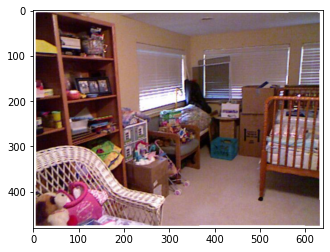

In [72]:
plt.imshow(np.uint8((images[idx]*255).numpy()))

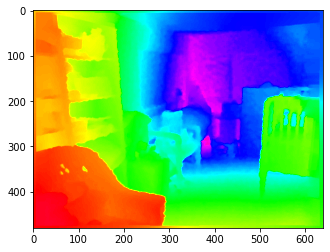

In [73]:
plt.imshow(depths[idx, :, : , 0],  cmap=plt.cm.gist_rainbow)


In [74]:
out1 = model.predict(tf.reshape(images[idx], [1, 480 , 640 , 3]))

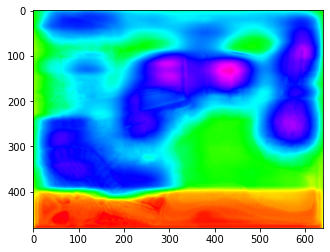

In [75]:
# ax3 = plt.subplot(2, 2, 3)
plt.imshow(out1[0, :, : , 0],  cmap=plt.cm.gist_rainbow)
# # ax3.set_title('depths')